# Introduction

In this notebook, I implement and visualize a **Perceptron** — a simple binary linear classifier — to predict whether an individual is a **smoker** based on selected features from the **insurance dataset**.

This is a **supervised learning task**, meaning we train our model on input-output pairs: features like age and BMI (inputs) and smoker status (output label).



## What is the Perceptron?

The perceptron is an early neural network model that:
- Computes a **weighted sum of inputs**
- Applies a **step function** to predict class labels (0 or 1)
- Updates weights based on misclassified examples using stochastic gradient descent

Mathematically:

$$
\hat{y} = \begin{cases} 
1 & \text{if } \mathbf{w}^\top \mathbf{x} + b \geq 0 \\0 & \text{otherwise}
\end{cases}
$$


### Load and Prepare Data
- Convert categorical `smoker` column into binary labels for classification.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load and preprocess the insurance dataset
df = pd.read_csv("../Datasets/insurance.csv")

# Select features for analysis
features = ['age', 'bmi', 'children', 'charges']
df = df.dropna(subset=features + ['smoker'])
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

### Visualize Feature Correlations

- A correlation matrix helps identify which features are most associated with smoking.
- `charges` and `bm` show strong correlation with smoker status — good feature candidates.


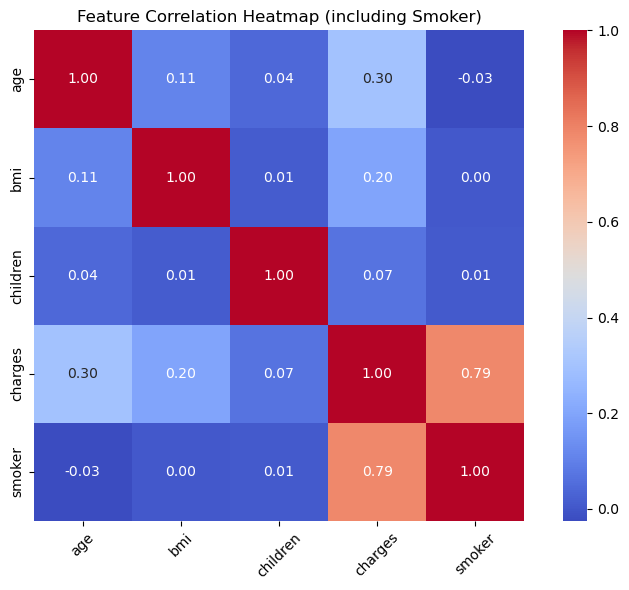

In [3]:
# ----- Heatmap to visualize correlations -----
plt.figure(figsize=(8, 6))
corr_matrix = df[features + ['smoker']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap (including Smoker)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This heatmap visualizes Pearson correlation coefficients between numeric features and the binary `smoker` label.

- **charges** and **smoker** show the strongest positive correlation (~0.79), indicating that higher medical costs are associated with smoking.
- **bmi** also shows moderate correlation (~0.43) with smoker status — heavier individuals are more likely to be smokers in this dataset.
- **age** has a weak positive correlation (~0.30), while **children** is almost uncorrelated (~0.07).

 Feature pairs involving `charges` and mi` are likely to perform better with linear classifiers like Perceptron.


### The Perceptron Model

- A custom `Perceptron` class handles training and prediction.
- Tracks both training and validation errors over time for performance analysis.

This

- Initializes the model with:
  - `eta`: the **learning rate** — controls how big each weight update is.
  - `epochs`: the number of times to iterate over the training data.

Trains the model using **stochastic gradient descent**, updating weights one sample at a time.


1. **Initialize weights**:  

2. **Training loop over epochs**:  

3. **Track errors**:  

4. **Validation check**: 

Computes the **linear combination** of weights and inputs:

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$

- Returns the raw score before applying the decision rule.

Applies the **unit step function**:

- If the net input is ≥ 0, predict **class 1**; otherwise, **class 0**.
- This is the **binary decision rule** that defines a perceptron.

In [4]:
# ----- Perceptron Model -----
class Perceptron:
    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X_train, y_train, X_val, y_val):
        self.w_ = np.random.rand(X_train.shape[1] + 1)
        self.train_errors_ = []
        self.val_errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X_train, y_train):
                update = self.eta * (target - self.predict(xi))
                self.w_[:-1] += update * xi
                self.w_[-1] += update
                errors += int(update != 0.0)
            self.train_errors_.append(errors)

            val_pred = np.array([self.predict(x) for x in X_val])
            val_error = np.sum(val_pred != y_val)
            self.val_errors_.append(val_error)

    def net_input(self, X):
        return np.dot(X, self.w_[:-1]) + self.w_[-1]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

###  Run Experiments on Feature Pairs
- For each pair of features (e.g., `age` and `bmi`), we:
  - Standardize the data
  - Train the perceptron
  - Plot the decision boundary
  - Show training vs validation errors

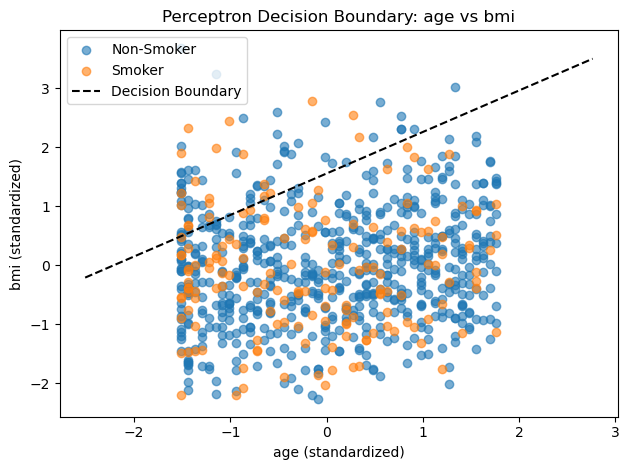

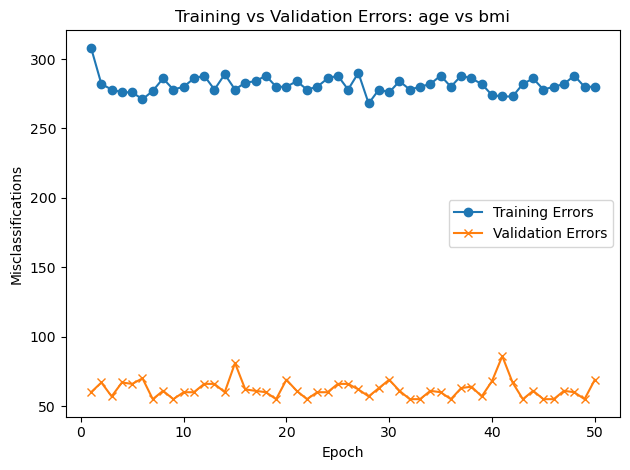

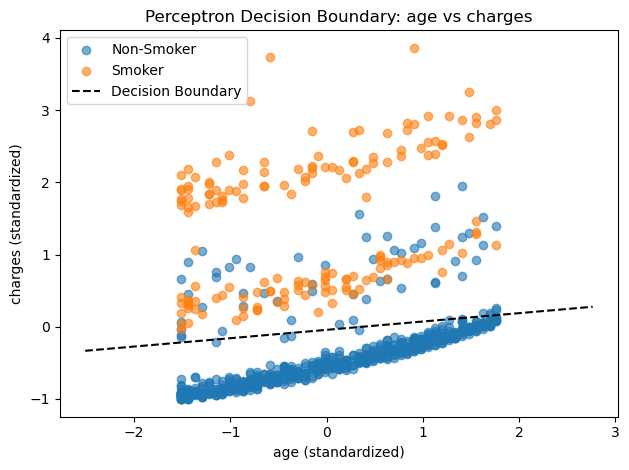

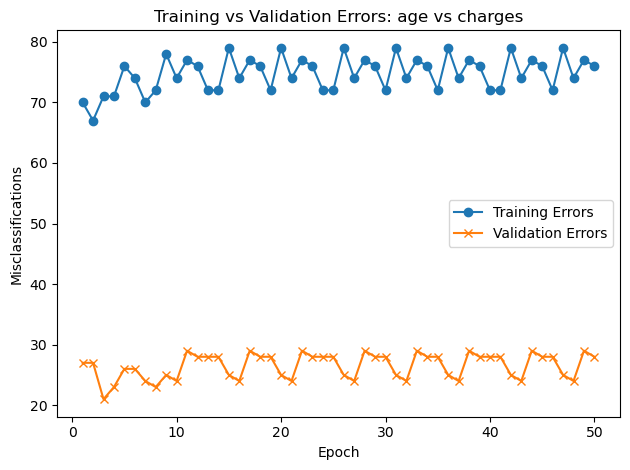

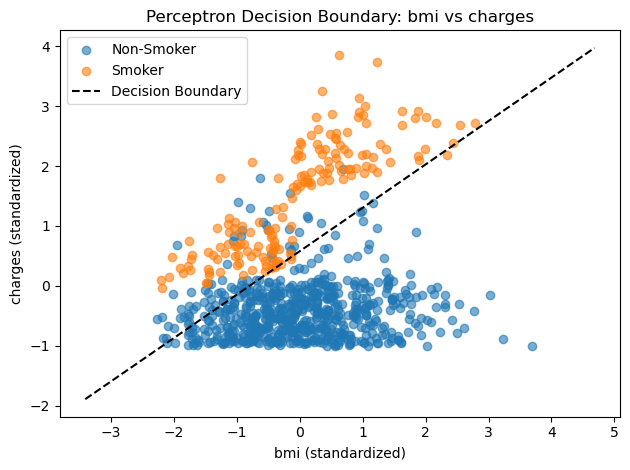

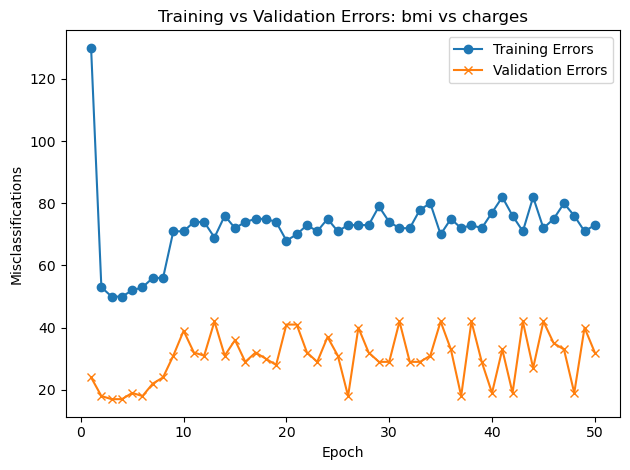

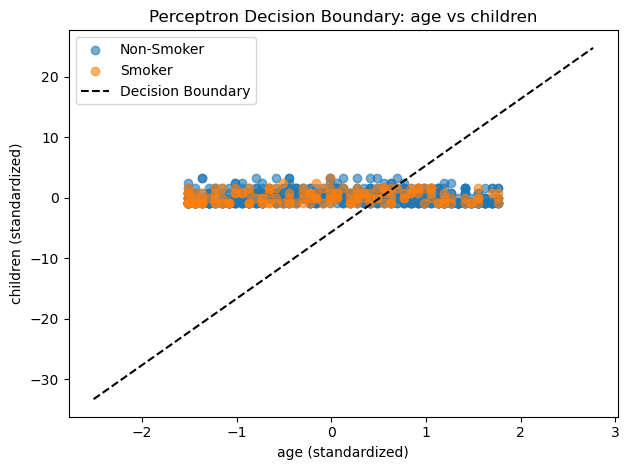

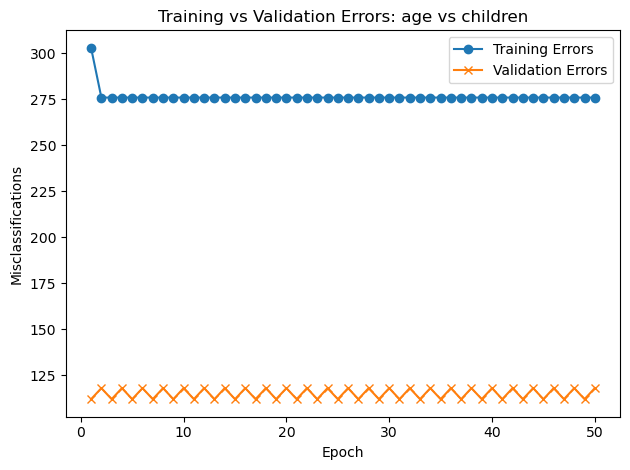

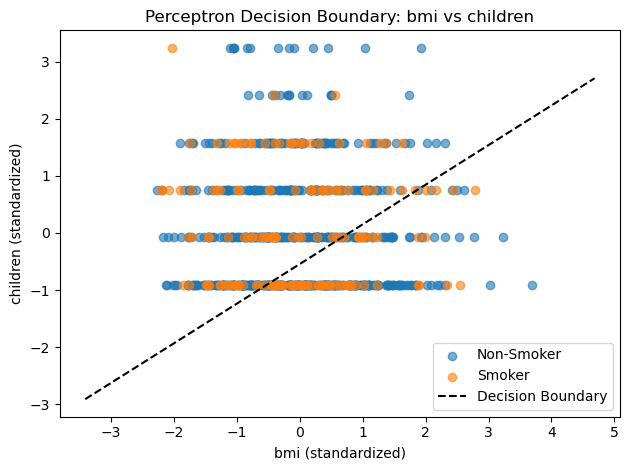

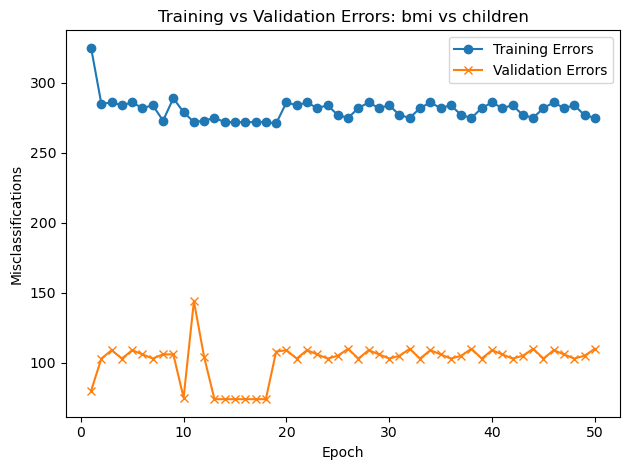

In [5]:

# ----- Function to run experiments -----
def run_perceptron_experiment(df, feature_x, feature_y, eta=0.01, epochs=50):
    df_pair = df.dropna(subset=[feature_x, feature_y, 'smoker']).copy()
    X_raw = df_pair[[feature_x, feature_y]].values
    y = df_pair['smoker'].values
    X_std = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

    # 60/20/20 split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

    model = Perceptron(eta=eta, epochs=epochs)
    model.train(X_train, y_train, X_val, y_val)

    # Decision boundary
    w = model.w_
    xs = np.linspace(X_std[:, 0].min() - 1, X_std[:, 0].max() + 1, 200)
    ys = -(w[0] * xs + w[2]) / w[1]

    # Plot boundary
    plt.figure()
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label="Non-Smoker", alpha=0.6)
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label="Smoker", alpha=0.6)
    plt.plot(xs, ys, 'k--', label="Decision Boundary")
    plt.xlabel(f"{feature_x} (standardized)")
    plt.ylabel(f"{feature_y} (standardized)")
    plt.title(f"Perceptron Decision Boundary: {feature_x} vs {feature_y}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot training vs validation error
    plt.figure()
    plt.plot(range(1, len(model.train_errors_) + 1), model.train_errors_, marker='o', label="Training Errors")
    plt.plot(range(1, len(model.val_errors_) + 1), model.val_errors_, marker='x', label="Validation Errors")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title(f"Training vs Validation Errors: {feature_x} vs {feature_y}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----- Run experiments for selected feature pairs -----
feature_pairs = [
    ('age', 'bmi'),
    ('age', 'charges'),
    ('bmi', 'charges'),
    ('age', 'children'),
    ('bmi', 'children')
]

for fx, fy in feature_pairs:
    run_perceptron_experiment(df, fx, fy)


### High-Performing Feature Pairs

#### 1. `bmi` vs `charges`
- **Decision Boundary**: Clear separation between smokers (orange) and non-smokers (blue), with a diagonal linear boundary doing a reasonable job.
- **Error Plot**: Training error stabilizes around 70, and validation error hovers between 20–40 — relatively low.
- **Conclusion**: This was the **best-performing feature pair**, with good linear separability and low misclassification.

#### 2. `age` vs `charges`
- **Decision Boundary**: Smokers and non-smokers show vertical separation, with smokers generally having higher charges.
- **Error Plot**: Training error is higher (~70–80), but validation error stays low and stable (~25–35).
- **Conclusion**: Works moderately well. `charges` helps, but `age` alone isn’t strongly predictive.


### Moderately Useful Feature Pair

#### `age` vs `bmi`
- **Decision Boundary**: Reasonable separation, though more overlap than `charges`.
- **Error Plot**: Training error is high (~280+), validation error is steady and lower (~50–60), indicating a consistent but imperfect classifier.
- **Conclusion**: This pair provides **moderate predictive power**, but not enough separation for confident predictions.

### Weak Feature Pairs

#### 1. `age` vs `children`
- **Decision Boundary**: The data is **clustered in rows** (children are discrete –5), making it difficult for a linear model to find a useful boundary.
- **Error Plot**: Training error stays very high (≈300), and validation error fluctuates around 100.
- **Conclusion**: This pair is **not linearly separable**, and children is not helpful as a feature.

#### 2. `bmi` vs `children`
- **Decision Boundary**: Similar row-like structure as above due to `children` being discrete.
- **Error Plot**: Training error remains high (~270), and validation error hovers around 100.
- **Conclusion**: Not useful for Perceptron classification; `children` introduces noise without separability.

### Overall

- **charges** consistently improves performance due to its strong correlation with `smoker`.
- **children** is a poor predictor — discrete and uncorrelated with smoking status.
- **Linear separability** is key: when features form distinct clusters, the Perceptron performs well.


# Conclusion and Future Work

- The perceptron is a **simple but effective binary classifier**.
- It works best when the data is **linearly separable**, which some feature pairs (e.g., `charges`, `bmi`) support.
- Custom implementation allowed tracking learning behavior and performance over time.

### Limitations

- The perceptron cannot model **non-linear decision boundaries**, making it unsuitable for overlapping or complex datasets.
- Only two features were used at a time — ignoring multi-feature interactions.
- The learning rate and number of epochs were not optimized.


### Future Steps

- Extend to **multi-layer perceptrons (MLP)** for non-linear decision boundaries.
- Add **more features** or apply **PCA** before training to capture deeper structure.
- Use scikit-learn’s built-in classifiers to compare against this custom implementation.
- Visualize **test set accuracy** and calculate precision, recall, and F1-score for a more complete evaluation.
